<a href="https://colab.research.google.com/github/mattwinkler/myapplications/blob/master/covid_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with VGG16 and Covid data for Image Classification.

Some ideas for further experimentation:

1) Adjust network topology of custom network by adding / removing additional layers  
2) Tune the learning rate  
3) Get more training data  
4) Implement LSTM on top of extracted image features from VGG16 model, for a CNN --> LSTM architecture  
5) Additional feature extraction  
6) Illustrate sections of images for covid positive samples that the model reacts strongly to, and focus further feature engineering efforts towards distinguishing those further  

In [1]:
#!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 34.06 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Checking out files: 100% (1048/1048), done.


In [0]:
#!unzip COVID-CT/Images-processed/CT_NonCOVID.zip
#!unzip COVID-CT/Images-processed/CT_COVID.zip

In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
n_covid = len(os.listdir('CT_COVID'))
n_non_covid = len(os.listdir('CT_NonCOVID'))

In [6]:
print('there are {} covid examples in the dataset'.format(str(n_covid)))
print('there are {} non-covid examples in the dataset'.format(str(n_non_covid)))

there are 349 covid examples in the dataset
there are 397 non-covid examples in the dataset


In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 16

In [8]:
#CUSTOM: Read covid images first to display them
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
covid_imagePaths = list(paths.list_images('CT_COVID'))
noncovid_imagePaths = list(paths.list_images('CT_NonCOVID'))
data = []
labels = []

[INFO] loading images...


showing covid positive example


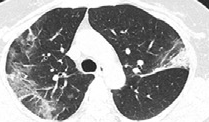


showing covid negative example


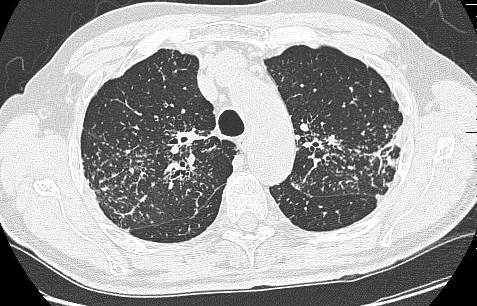

In [9]:
#CUSTOM: Show an example image
from google.colab.patches import cv2_imshow
n = 0
print('showing covid positive example')
cv2_imshow(cv2.imread(covid_imagePaths[n]))
print('')
print('showing covid negative example')
cv2_imshow(cv2.imread(noncovid_imagePaths[n]))

Read Datasets into arrays for training

In [0]:
# CUSTOM: Read extracted COVID data files
# loop over the positive example image paths
for imagePath in covid_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label) # append covid positive label

# loop over the negative example image paths
for imagePath in noncovid_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label) # append covid negative label

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [11]:
# CUSTOM: show shape of training data
print('showing shape of training + validation data')
data.shape

showing shape of training + validation data


(746, 224, 224, 3)

In [0]:
# CUSTOM: Create 80/10/10 train/validation/test dataset splits
# Calling train_test_split twice is suboptimal and will cause performance problems with larger datasets, 
# But works as a quick method of dividing smaller data
# holdoutX and holdoutY are the data preserved for 

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, holdoutX, trainY, holdoutY) = train_test_split(data, labels, 
  test_size=0.10, stratify=labels, random_state=42)

# partition the data into training, validation, and testing splits using 80% of
# the data for training, 10% for validation and 10% for testing
(trainX, testX, trainY, testY) = train_test_split(trainX, trainY,
	test_size=0.11, stratify=trainY, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [13]:
trainX.shape

(597, 224, 224, 3)

In [14]:
testX.shape

(74, 224, 224, 3)

In [15]:
holdoutX.shape

(75, 224, 224, 3)

In [16]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train using transfer learning)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
37/37 [==============================] - 210s 6s/step - loss: 0.8487 - accuracy: 0.5301 - val_loss: 0.6687 - val_accuracy: 0.5405
Epoch 2/25
37/37 [==============================] - 213s 6s/step - loss: 0.6799 - accuracy: 0.5594 - val_loss: 0.6430 - val_accuracy: 0.6757
Epoch 3/25
37/37 [==============================] - 212s 6s/step - loss: 0.6477 - accuracy: 0.6093 - val_loss: 0.6317 - val_accuracy: 0.6486
Epoch 4/25
37/37 [==============================] - 212s 6s/step - loss: 0.6127 - accuracy: 0.6781 - val_loss: 0.6564 - val_accuracy: 0.5946
Epoch 5/25
37/37 [==============================] - 213s 6s/step - loss: 0.6121 - accuracy: 0.6609 - val_loss: 0.6161 - val_accuracy: 0.7432
Epoch 6/25
37/37 [==============================] - 212s 6s/step - loss: 0.5981 - accuracy: 0.6936 - val_loss: 0.6197 - val_accuracy: 0.6216
Epoch 7/25
37/37 [==============================] - 212s 6s/step - loss: 0.5898 - accuracy: 0.7074 - val

In [18]:
#CUSTOM: changed testX to holdoutX

# make predictions on the testing set
print("[INFO] evaluating network on holdout data")
predIdxs = model.predict(holdoutX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#CUSTOM: passed ['COVID', 'NON-COVID'] to target_names instead of lb.classes_
# show a nicely formatted classification report
print(classification_report(holdoutY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network on holdout data
              precision    recall  f1-score   support

    CT_COVID       0.64      0.83      0.73        35
 CT_NonCOVID       0.80      0.60      0.69        40

    accuracy                           0.71        75
   macro avg       0.72      0.71      0.71        75
weighted avg       0.73      0.71      0.70        75



In [19]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(holdoutY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[29  6]
 [16 24]]
acc: 0.7067
sensitivity: 0.8286
specificity: 0.6000


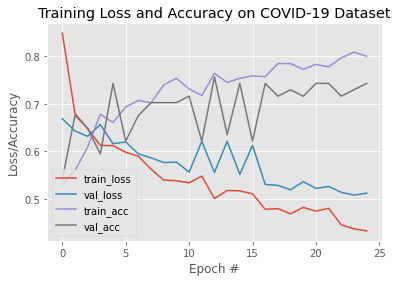

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('training summary')

In [21]:
# CUSTOM: save model with timestamp
# serialize the model to disk
from datetime import datetime
model_name = datetime.now().strftime('covid-detector-%Y-%m-%d-%H-%M.h5')
print("[INFO] saving COVID-19 detector model...")
model.save(model_name, save_format="h5")

[INFO] saving COVID-19 detector model...
